In [ ]:
import os
import numpy as np

from itertools import combinations
from scipy.spatial import cKDTree
from IPython.display import display
import pandas as pd
from math import sqrt

from sklearn.cluster import DBSCAN
import cv2
import networkx as nx
from collections import Counter
import random

import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.csgraph import connected_components
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.colors import ListedColormap
import matplotlib
import matplotlib.colors as mcolors
cmap = ListedColormap(['grey', 'red'])
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

DATA_PATH = "/mnt/cai-data/manuscript-annotation-tool/manuscripts/eeml-submission/points-2D"
IMG_PATH = "/mnt/cai-data/manuscript-annotation-tool/manuscripts/eeml-submission/leaves"




NUM_NEIGHBOURS = 8
cos_similarity_less_than = -0.8
%matplotlib widget


In [ ]:

# HELPER FUNCTIONS
def convert_to_graph(to_plot, points):
    # Create an empty graph
    G = nx.Graph()
    
    # Add all points as nodes with their coordinates as features
    for i, point in enumerate(points):
        G.add_node(i, pos=point)
    
    # Add edges from to_plot, avoiding duplicates (NetworkX handles this automatically)
    for center, neighbor1, neighbor2 in to_plot:
        G.add_edge(center, neighbor1)
        G.add_edge(center, neighbor2)
    
    # Create adjacency matrix
    adj_matrix = nx.to_numpy_array(G)
    
    # Create feature matrix (each row contains the x,y coordinates of a point)
    feature_matrix = np.array([G.nodes[i]['pos'] for i in range(len(points))])
    
    return G, adj_matrix, feature_matrix


def cluster_with_single_majority(to_cluster, eps=10, min_samples=2):
    """
    Clusters data, identifying only one majority cluster and marking all other points as outliers.

    Args:
        to_cluster: List of data points to cluster.
        eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
        min_samples: The number of samples in a neighborhood for a point to be considered as a core point.

    Returns:
        NumPy array of labels, where the majority cluster is labeled 0, and all other points are labeled -1.
    """
    to_cluster_array = np.array(to_cluster)

    if len(to_cluster_array) == 0:
      return np.array([])

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(to_cluster_array)

    # Count the occurrences of each label
    label_counts = Counter(labels)

    # Find the majority cluster label (excluding -1 outliers)
    majority_label = None
    max_count = 0
    for label, count in label_counts.items():
        if label != -1 and count > max_count:
            majority_label = label
            max_count = count

    # Create a new label array where the majority cluster is 0 and all others are -1
    new_labels = np.full(len(labels), -1)  # Initialize all as outliers

    if majority_label is not None:
        new_labels[labels == majority_label] = 0  # Assign 0 to the majority cluster

    return new_labels





In [ ]:

def generate_graph(pg_no):
    # Get unique prefixes efficiently without sorting everything
    for entry in os.scandir(DATA_PATH):
        # if entry.is_file() and entry.name.endswith(f'{pg_no}.txt'):
        if entry.is_file() and entry.name == f'{pg_no}_points.txt':



            points_file = entry.path
            print(f"Processing file: {points_file}")
            points = np.loadtxt(points_file)
            points[:, 1] = height - points[:, 1]
            
            # Build a KD-tree for fast neighbor lookup
            tree = cKDTree(points)
            _, indices = tree.query(points, k=NUM_NEIGHBOURS)
            
            segments = []
            seg_colors = [] 

            to_cluster = []
            to_plot = []

            # Process nearest neighbors
            for current_point_index, nbr_indices in enumerate(indices):
                normalized_points = points[nbr_indices] - points[current_point_index]
                scaling_factor = np.max(np.abs(normalized_points))
                if scaling_factor == 0:
                    scaling_factor = 1
                scaled_points = normalized_points / scaling_factor
                relative_neighbours = [(global_idx, sp, np)
                                    for global_idx, sp, np in zip(nbr_indices, scaled_points, normalized_points)]
                

                filtered_neighbours = []
                for _a, _b in combinations(relative_neighbours, 2):
                    # calculate the angle between the two pair vectors
                    if np.linalg.norm(_a[1]) * np.linalg.norm(_b[1]) == 0:
                        cos_similarity = 0.0
                    else:
                        cos_similarity = np.dot(_a[1], _b[1]) / (np.linalg.norm(_a[1]) * np.linalg.norm(_b[1]))

                    # calculate the non-normalized length of the pair
                    norm1 = np.linalg.norm(_a[2])
                    norm2 = np.linalg.norm(_b[2])
                    total_length = norm1 + norm2

                    # select pairs who have an angle of around 180 degrees between them
                    if cos_similarity < cos_similarity_less_than:
                        filtered_neighbours.append((_a, _b, total_length, cos_similarity))

                if filtered_neighbours:
                    # select the pair with the shortest total_length (sometimes, the 2nd shortest is the right answer)
                    shortest_pair = min(filtered_neighbours, key=lambda x: x[2])

                    _connection_1, _connection_2, total_length, cos_similarity = shortest_pair
                    global_idx_connection_1 = _connection_1[0]
                    global_idx_connection_2 = _connection_2[0]

                    # calculate the angles made with the X-axis for clustering purpose
                    theta_a = np.degrees(np.arctan2(_connection_1[2][1], _connection_1[2][0]))
                    theta_b = np.degrees(np.arctan2(_connection_2[2][1], _connection_2[2][0]))
                    theta = (theta_a,theta_b)
                    
                    to_plot.append((current_point_index, global_idx_connection_1, global_idx_connection_2))
                    
                    # Add new informative features for improved clustering
                    y_diff1 = abs(_connection_1[2][1])  # Vertical distance component
                    y_diff2 = abs(_connection_2[2][1])
                    avg_y_diff = (y_diff1 + y_diff2) / 2
                    
                    x_diff1 = abs(_connection_1[2][0])  # Horizontal distance component
                    x_diff2 = abs(_connection_2[2][0])
                    avg_x_diff = (x_diff1 + x_diff2) / 2
                    
                    # Calculate aspect ratio of the connection (height/width)
                    aspect_ratio = avg_y_diff / max(avg_x_diff, 0.001)  # Avoid division by zero
                    
                    # Calculate vertical alignment consistency (low value = better alignment)
                    vert_consistency = abs(y_diff1 - y_diff2)
                    
                    to_cluster.append((
                        total_length, 
                        #np.abs(theta[0]+theta[1]),
                        aspect_ratio,
                        vert_consistency,
                        avg_y_diff  # Vertical distance is important for line detection
                    ))


            to_cluster_array = np.array(to_cluster)  # Convert list to NumPy array
            labels = cluster_with_single_majority(to_cluster)



            # removing red (outliers detected by clustering)
            mask = labels != -1
            # Filter labels using the mask
            filtered_labels = labels[mask]
            # Filter to_plot using the same mask
            filtered_to_plot = [item for i, item in enumerate(to_plot) if mask[i]]

            # Create the graph and matrices
            G_generated, adjacency_matrix, feature_matrix = convert_to_graph(filtered_to_plot , points)
            # thus we have a graph, where nodes represent the presence of a character, and characters(nodes) who are part of the same line have edges (are connected) to previous and next characters

            return G_generated


## Evaluation

In [ ]:
def get_ground_truth_graph(pg_no):
    # Read the files
    points = np.loadtxt(DATA_PATH+f'/{pg_no}_points.txt')
    labels = np.loadtxt(DATA_PATH+f'/{pg_no}_labels.txt', dtype=int)
    points[:, 1] = height - points[:, 1]

    # Create an empty graph for the ground truth
    G_truth = nx.Graph()

    # Add nodes with their positions and labels
    for i, (point, label) in enumerate(zip(points, labels)):
        G_truth.add_node(i, pos=tuple(point), label=label)

    # For each label, connect all points using the Minimum Spanning Tree (MST)
    unique_labels = np.unique(labels)
    for lab in unique_labels:
        # Get all indices for the current label
        indices = [i for i, l in enumerate(labels) if l == lab]
        if len(indices) > 1:
            # Create a complete graph for these nodes with edge weights as Euclidean distances
            H = nx.Graph()
            for i in indices:
                H.add_node(i, pos=G_truth.nodes[i]['pos'])
            for idx, i in enumerate(indices):
                for j in indices[idx+1:]:
                    p1 = G_truth.nodes[i]['pos']
                    p2 = G_truth.nodes[j]['pos']
                    dist = sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
                    H.add_edge(i, j, weight=dist)
            # Compute the MST for this group, which connects all points with the minimum required edges
            MST = nx.minimum_spanning_tree(H)
            # Add the MST edges to the ground truth graph
            for edge in MST.edges:
                G_truth.add_edge(*edge)

    print("Ground truth graph edges:", list(G_truth.edges))



    return G_truth


In [ ]:
def evaluate(G_truth, G_generated):
    # Compute edge sets as sorted tuples for consistency
    edges_truth = {tuple(sorted(edge)) for edge in G_truth.edges}
    edges_generated = {tuple(sorted(edge)) for edge in G_generated.edges}

    correct_edges = edges_truth & edges_generated
    extra_edges = edges_generated - edges_truth
    missing_edges = edges_truth - edges_generated

    print("Correct edges:", len(correct_edges))
    print("Extra edges (wrong):", len(extra_edges))
    print("Missing edges:", len(missing_edges))


    return len(correct_edges), len(extra_edges), len(missing_edges)


In [ ]:
# Initialize empty lists to store results
results = []

# Process all 14 pages
for pg_no in range(14):
    # Load and resize background image
    bg_img = plt.imread(IMG_PATH+f"/{pg_no}.jpg")  # Replace with your image path
    bg_img = cv2.resize(bg_img, (bg_img.shape[1] // 2, bg_img.shape[0] // 2))
    height, width = bg_img.shape[:2]
    
    # Generate and evaluate graphs
    G_generated = generate_graph(pg_no)
    G_truth = get_ground_truth_graph(pg_no)
    correct_edges, extra_edges, missing_edges = evaluate(G_truth, G_generated)
    
    # Calculate metrics
    total_truth_edges = len(G_truth.edges())
    total_generated_edges = len(G_generated.edges())
    
    precision = correct_edges / total_generated_edges if total_generated_edges > 0 else 0
    recall = correct_edges / total_truth_edges if total_truth_edges > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Append results to list
    results.append({
        'Page': pg_no,
        'Correct Edges': correct_edges,
        'Extra Edges': extra_edges,
        'Missing Edges': missing_edges,
        'Total Truth Edges': total_truth_edges,
        'Total Generated Edges': total_generated_edges,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    
    # Optional: Print progress
    print(f"Processed page {pg_no}")

# Create pandas DataFrame from results
results_df = pd.DataFrame(results)

# Calculate summary statistics
summary = {
    'Page': 'Summary',
    'Correct Edges': results_df['Correct Edges'].sum(),
    'Extra Edges': results_df['Extra Edges'].sum(),
    'Missing Edges': results_df['Missing Edges'].sum(),
    'Total Truth Edges': results_df['Total Truth Edges'].sum(),
    'Total Generated Edges': results_df['Total Generated Edges'].sum(),
    'Precision': results_df['Correct Edges'].sum() / results_df['Total Generated Edges'].sum() if results_df['Total Generated Edges'].sum() > 0 else 0,
    'Recall': results_df['Correct Edges'].sum() / results_df['Total Truth Edges'].sum() if results_df['Total Truth Edges'].sum() > 0 else 0,
    'F1 Score': np.nan  # Will be calculated below
}

# Calculate overall F1 score
summary['F1 Score'] = 2 * summary['Precision'] * summary['Recall'] / (summary['Precision'] + summary['Recall']) if (summary['Precision'] + summary['Recall']) > 0 else 0

# Add summary row to DataFrame
results_df = pd.concat([results_df, pd.DataFrame([summary])], ignore_index=True)

# Display the results DataFrame
print("\nEvaluation Results:")
print(results_df.to_string(index=False))

# Optionally, format the floating-point columns for better readability
formatted_df = results_df.copy()
for col in ['Precision', 'Recall', 'F1 Score']:
    formatted_df[col] = formatted_df[col].map('{:.4f}'.format)

print("\nFormatted Evaluation Results:")
print(formatted_df.to_string(index=False))

## Seamformer eval

In [ ]:
import json

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import Polygon as MatplotlibPolygon
import random
import colorsys

def point_in_polygon(point, polygon):
    """Check if a point is inside a polygon using matplotlib's Path."""
    path = Path(polygon)
    return path.contains_point(point)

def label_points(points, polygons):
    """
    Label each point based on which polygon contains it.
    Returns:
    - labels: array of same length as points, with values indicating polygon index
              -1 indicates point is not in any polygon
    """
    labels = np.full(len(points), -1)  # Default: not in any polygon
    
    for i, polygon in enumerate(polygons):
        # Convert polygon to numpy array if it's not already
        poly_array = np.array(polygon)
        
        # Create path for efficient checking
        path = Path(poly_array)
        
        # Check all points at once for this polygon
        inside_mask = path.contains_points(points)
        
        # Only set labels for points not already labeled
        # This handles potential overlapping polygons - first polygon gets priority
        labels[np.logical_and(inside_mask, labels == -1)] = i
    
    return labels

def generate_distinct_colors(n_colors):
    """Generate visually distinct colors."""
    colors = []
    for i in range(n_colors):
        # Use HSV color space for more distinct colors
        hue = i / n_colors
        saturation = 0.8 + random.uniform(-0.2, 0.2)  # Add slight randomness
        value = 0.8 + random.uniform(-0.2, 0.2)
        colors.append(colorsys.hsv_to_rgb(hue, saturation, value))
    return colors

def visualize_labeled_points(points, polygons, labels):
    """Visualize the points colored by label and the polygons."""
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Count number of unique labels (excluding -1)
    unique_labels = np.unique(labels)
    positive_labels = unique_labels[unique_labels >= 0]
    n_labels = len(positive_labels)
    
    # Generate colors for each label and polygon
    # Add one more color for unlabeled points
    colors = generate_distinct_colors(n_labels + 1)
    
    # Draw polygons with transparency
    for i, polygon in enumerate(polygons):
        if i < n_labels:  # Ensure we don't go beyond available colors
            poly = MatplotlibPolygon(np.array(polygon), 
                                     alpha=0.3, 
                                     fill=True, 
                                     color=colors[i],
                                     label=f'Polygon {i}')
            ax.add_patch(poly)
    
    # Plot points, colored by their label
    for label in unique_labels:
        mask = labels == label
        if label == -1:
            # Use the last color for unlabeled points
            ax.scatter(points[mask, 0], points[mask, 1], color='gray', 
                       alpha=0.7, label='Unlabeled')
        else:
            ax.scatter(points[mask, 0], points[mask, 1], color=colors[int(label)], 
                       alpha=0.7, label=f'Label {label}')
    
    ax.set_title('Points Labeled by Containing Polygon')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    ax.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    return fig

def scale_polygons(polygons, scale_factor=0.5):
    """Scale all polygons by the given factor (default: 0.5 for scaling down by 2)"""
    scaled_polygons = []
    
    for polygon in polygons:
        # Convert to numpy array for easier manipulation
        poly_array = np.array(polygon)
        
        # Scale coordinates
        scaled_poly = poly_array * scale_factor
        
        # Convert back to list format
        scaled_polygons.append(scaled_poly.tolist())
    
    return scaled_polygons

# Usage:


# Example usage (you'll need to replace with your actual data):
# points = np.loadtxt(DATA_PATH+f'/{pg_no}_points.txt')
# bounding_polygons = data[idx]['predPolygons']

# label the points
# labels = label_points(points, bounding_polygons)

# visualize the results
# fig = visualize_labeled_points(points, bounding_polygons, labels)
# plt.show()

In [ ]:
# import seamformer results
json_file_path = "/home/kartik/layout-analysis/seamformer/seamformer/data/output/eeml-data/v0.json"

# Open and load the JSON file
with open(json_file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

# Print the loaded data
print(json.dumps(data, indent=4))

In [ ]:
idx = 0
pg_no = data[idx]['imgPath'].split("/")[-1].split('.')[0]
print(pg_no)
img_H = data[idx]['imgDims'][0]
img_W = data[idx]['imgDims'][1]

points = np.loadtxt(DATA_PATH+f'/{pg_no}_points.txt') # array with 2D points
#points[:, 1] = img_H - points[:, 1]

# Visualize the results
fig = visualize_labeled_points(points, scaled_bounding_polygons, labels)
plt.show()

In [ ]:
def get_seamformer_graph(idx,data):
    # Read the files
    pg_no = data[idx]['imgPath'].split("/")[-1].split('.')[0]
    points = np.loadtxt(DATA_PATH+f'/{pg_no}_points.txt')
    height = int(data[idx]['imgDims'][0]/2) #scale down by 2
    bounding_polygons = data[idx]['predPolygons'] # A list of list(polygons) of list(2D coordinates)
    scaled_bounding_polygons = scale_polygons(bounding_polygons) # scale down by 2
    # Label the points
    labels = label_points(points, scaled_bounding_polygons)


    
    points[:, 1] = height - points[:, 1]

    # Create an empty graph for the ground truth
    G_truth = nx.Graph()

    # Add nodes with their positions and labels
    for i, (point, label) in enumerate(zip(points, labels)):
        G_truth.add_node(i, pos=tuple(point), label=label)

    # For each label, connect all points using the Minimum Spanning Tree (MST)
    unique_labels = np.unique(labels)
    for lab in unique_labels:
        # Get all indices for the current label
        indices = [i for i, l in enumerate(labels) if l == lab]
        if len(indices) > 1:
            # Create a complete graph for these nodes with edge weights as Euclidean distances
            H = nx.Graph()
            for i in indices:
                H.add_node(i, pos=G_truth.nodes[i]['pos'])
            for idx, i in enumerate(indices):
                for j in indices[idx+1:]:
                    p1 = G_truth.nodes[i]['pos']
                    p2 = G_truth.nodes[j]['pos']
                    dist = sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
                    H.add_edge(i, j, weight=dist)
            # Compute the MST for this group, which connects all points with the minimum required edges
            MST = nx.minimum_spanning_tree(H)
            # Add the MST edges to the ground truth graph
            for edge in MST.edges:
                G_truth.add_edge(*edge)

    print("Ground truth graph edges:", list(G_truth.edges))



    return G_truth, pg_no


In [ ]:
def evaluate(G_truth, G_generated):
    # Compute edge sets as sorted tuples for consistency
    edges_truth = {tuple(sorted(edge)) for edge in G_truth.edges}
    edges_generated = {tuple(sorted(edge)) for edge in G_generated.edges}

    correct_edges = edges_truth & edges_generated
    extra_edges = edges_generated - edges_truth
    missing_edges = edges_truth - edges_generated

    print("Correct edges:", len(correct_edges))
    print("Extra edges (wrong):", len(extra_edges))
    print("Missing edges:", len(missing_edges))

    # Use positions from the ground truth graph (assuming nodes have 'pos' attribute)
    pos = nx.get_node_attributes(G_truth, 'pos')

    plt.figure(figsize=(12, 6))
    ax = plt.gca()  # Get current axes
    plt.imshow(bg_img, alpha=0.4, zorder=0, extent=[0, width, 0, height])
    ax.set_xlim(0, width)  # Use ax.set_xlim instead of plt.set_xlim
    ax.set_ylim(0, height)  # Use ax.set_ylim instead of plt.set_ylim

    # Draw nodes
    nx.draw_networkx_nodes(G_truth, pos, node_color='white', node_size=18)

    # Draw correct edges in blue-green (teal)
    nx.draw_networkx_edges(G_truth, pos, edgelist=list(correct_edges), edge_color='#009E73', width=4, label='Correct')

    # Draw extra edges in orange
    if extra_edges:
        nx.draw_networkx_edges(G_generated, pos, edgelist=list(extra_edges), edge_color='#E69F00', width=4, label='Extra (Wrong)')

    # Draw missing edges in purple
    if missing_edges:
        nx.draw_networkx_edges(G_truth, pos, edgelist=list(missing_edges), edge_color='#CC79A7', width=4, label='Missing')

    # Draw node labels
    nx.draw_networkx_labels(G_truth, pos, font_size=1, font_color='black')

    # Lines for edge types in the legend
    correct_line = mlines.Line2D([], [], color='#009E73', lw=2, label='Correct Edge')
    extra_line = mlines.Line2D([], [], color='#E69F00', lw=2,  label='Extra Edge')
    missing_line = mlines.Line2D([], [], color='#CC79A7', lw=2,  label='Missing Edge')

    # White dot with black edge for character presence
    character_marker = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                    markerfacecolor='white', markeredgecolor='black', 
                                    markersize=10, label='Node (Character)')

    # Add legend
    plt.legend(handles=[correct_line, extra_line, missing_line, character_marker], loc='best')

    # plt.title("Evaluation: Correct (green), Extra (orange), Missing (blue)")
    plt.axis('off')
    plt.show()

    return len(correct_edges), len(extra_edges), len(missing_edges)

Ground truth graph edges: [(0, 1), (0, 2), (3, 6), (4, 5), (4, 169), (5, 8), (6, 7), (7, 86), (8, 9), (10, 15), (11, 12), (11, 14), (12, 15), (13, 19), (13, 16), (14, 16), (17, 20), (17, 18), (18, 23), (19, 21), (20, 21), (22, 23), (22, 28), (24, 28), (24, 29), (25, 26), (25, 32), (26, 27), (27, 33), (29, 31), (30, 33), (30, 31), (32, 35), (34, 37), (34, 36), (35, 36), (37, 40), (38, 39), (38, 44), (39, 40), (41, 47), (41, 42), (42, 45), (43, 44), (43, 46), (45, 46), (48, 49), (48, 56), (50, 52), (50, 61), (51, 58), (51, 55), (52, 57), (53, 54), (53, 55), (54, 59), (56, 58), (57, 59), (60, 63), (60, 62), (61, 64), (62, 69), (63, 64), (65, 66), (65, 67), (66, 71), (67, 68), (68, 70), (69, 70), (71, 72), (72, 75), (73, 76), (73, 77), (74, 77), (74, 75), (76, 80), (78, 79), (78, 82), (79, 80), (81, 83), (81, 84), (82, 84), (85, 90), (86, 121), (87, 90), (87, 89), (88, 89), (88, 95), (91, 98), (91, 94), (92, 93), (92, 101), (93, 96), (94, 97), (95, 98), (96, 97), (99, 103), (99, 102), (100

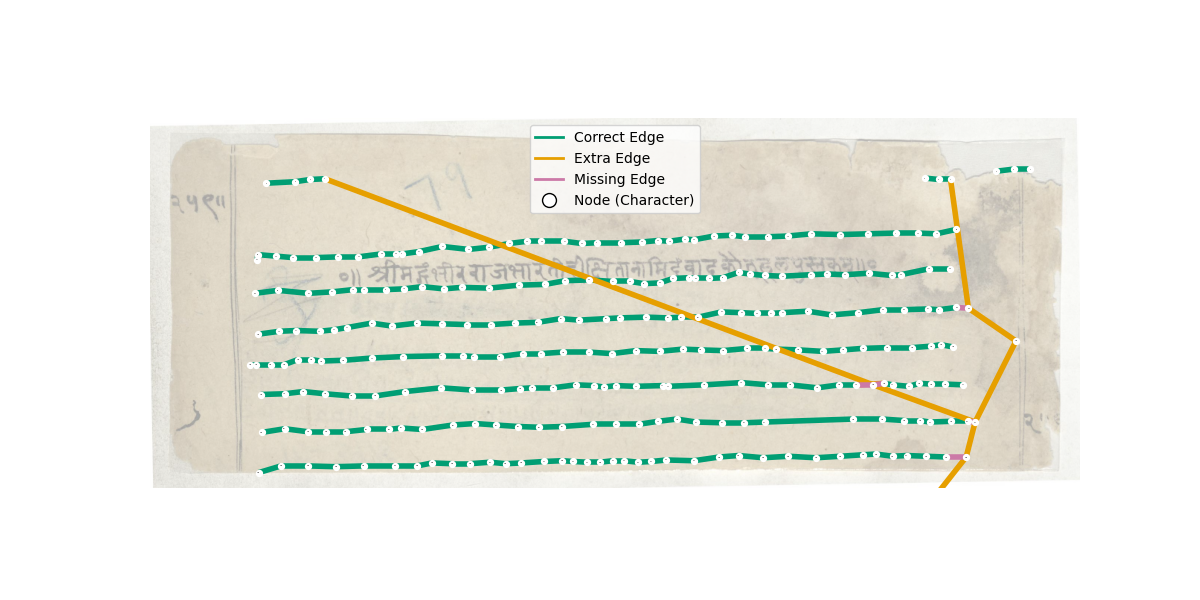

(246, 8, 5)

In [68]:
G_seamformer,pg_no = get_seamformer_graph(4,data)
print(pg_no)
G_truth = get_ground_truth_graph(pg_no)
evaluate(G_truth,G_seamformer)

In [ ]:
# # Initialize empty lists to store results
# results = []

# # Process all 14 pages
# for pg_no in range(14):
#     # Load and resize background image
#     bg_img = plt.imread(IMG_PATH+f"/{pg_no}.jpg")  # Replace with your image path
#     bg_img = cv2.resize(bg_img, (bg_img.shape[1] // 2, bg_img.shape[0] // 2))
#     height, width = bg_img.shape[:2]
    
#     # Generate and evaluate graphs
#     G_generated = generate_graph(pg_no)
#     G_truth = get_ground_truth_graph(pg_no)
#     correct_edges, extra_edges, missing_edges = evaluate(G_truth, G_generated)
    
#     # Calculate metrics
#     total_truth_edges = len(G_truth.edges())
#     total_generated_edges = len(G_generated.edges())
    
#     precision = correct_edges / total_generated_edges if total_generated_edges > 0 else 0
#     recall = correct_edges / total_truth_edges if total_truth_edges > 0 else 0
#     f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
#     # Append results to list
#     results.append({
#         'Page': pg_no,
#         'Correct Edges': correct_edges,
#         'Extra Edges': extra_edges,
#         'Missing Edges': missing_edges,
#         'Total Truth Edges': total_truth_edges,
#         'Total Generated Edges': total_generated_edges,
#         'Precision': precision,
#         'Recall': recall,
#         'F1 Score': f1
#     })
    
#     # Optional: Print progress
#     print(f"Processed page {pg_no}")

# # Create pandas DataFrame from results
# results_df = pd.DataFrame(results)

# # Calculate summary statistics
# summary = {
#     'Page': 'Summary',
#     'Correct Edges': results_df['Correct Edges'].sum(),
#     'Extra Edges': results_df['Extra Edges'].sum(),
#     'Missing Edges': results_df['Missing Edges'].sum(),
#     'Total Truth Edges': results_df['Total Truth Edges'].sum(),
#     'Total Generated Edges': results_df['Total Generated Edges'].sum(),
#     'Precision': results_df['Correct Edges'].sum() / results_df['Total Generated Edges'].sum() if results_df['Total Generated Edges'].sum() > 0 else 0,
#     'Recall': results_df['Correct Edges'].sum() / results_df['Total Truth Edges'].sum() if results_df['Total Truth Edges'].sum() > 0 else 0,
#     'F1 Score': np.nan  # Will be calculated below
# }

# # Calculate overall F1 score
# summary['F1 Score'] = 2 * summary['Precision'] * summary['Recall'] / (summary['Precision'] + summary['Recall']) if (summary['Precision'] + summary['Recall']) > 0 else 0

# # Add summary row to DataFrame
# results_df = pd.concat([results_df, pd.DataFrame([summary])], ignore_index=True)

# # Display the results DataFrame
# print("\nEvaluation Results:")
# print(results_df.to_string(index=False))

# # Optionally, format the floating-point columns for better readability
# formatted_df = results_df.copy()
# for col in ['Precision', 'Recall', 'F1 Score']:
#     formatted_df[col] = formatted_df[col].map('{:.4f}'.format)

# print("\nFormatted Evaluation Results:")
# print(formatted_df.to_string(index=False))